In [1]:
import json
with open('results.json', 'r') as fp:
    res = json.load(fp)
data = []
for entry in res:
    data += entry['data']['users']

In [2]:
import json
with open('arb_results.json', 'r') as fp:
    res = json.load(fp)
arb_data = []
for entry in res:
    arb_data += entry['data']['users']

In [44]:
from utils.gho_filter import filter_gho_users
histories = ['borrowHistory']

gho_users = filter_gho_users(data, histories)
print("Mainnet GHO Users: ", len(gho_users))

arb_gho_users = filter_gho_users(arb_data, histories)
print("Arbitrum GHO Users: ", len(arb_gho_users))

Mainnet GHO Users:  2297
Arbitrum GHO Users:  636


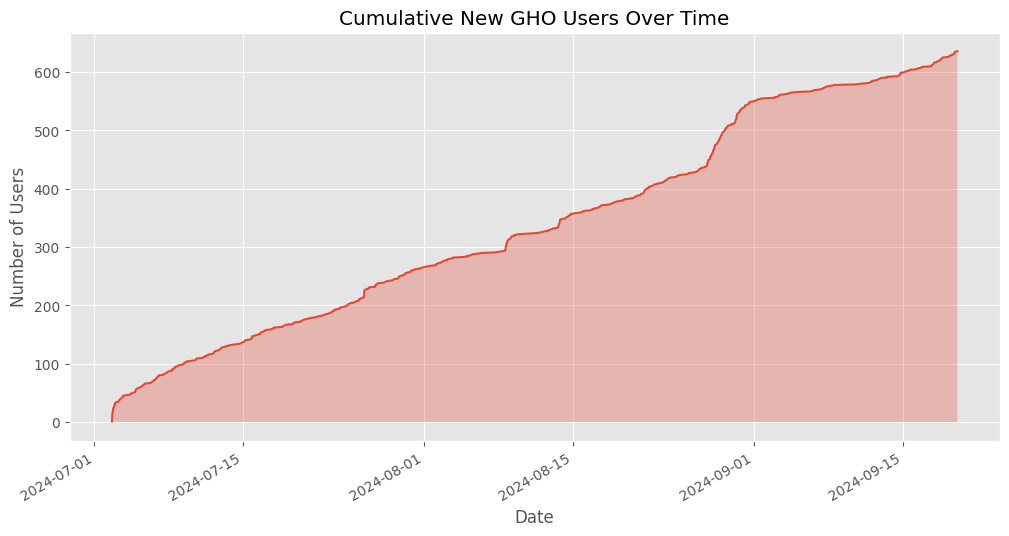

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def get_gho_usage(history: dict, action: str) -> bool:
    for action in history[action]:
        if 'reserve' in action:
            if action['reserve']['symbol'] == 'GHO':
                return True
    return False
    
user_transactions = {}
first_transactions = {}
full_transactions = {}
mint_transactions = set()
for history in histories:
    for entry in arb_data:
        if get_gho_usage(entry, history):
            user_gho_transactions = [c['txHash'] for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            user_transactions[entry['id']] = len(user_gho_transactions)
            mint_transactions |= set(user_gho_transactions)
            first_transaction = min([c['timestamp'] for c in entry[history] if c['reserve']['symbol'] == 'GHO'])
            first_transactions[entry['id']] = first_transaction
            full_transactions[entry['id']] = [c for c in entry[history] if c['reserve']['symbol'] == 'GHO']
            
plt.style.use('ggplot')
df = pd.DataFrame.from_dict(first_transactions, orient='index', columns=['timestamp'])
df.index.name = 'user'
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values('timestamp')
df['cumulative_users'] = range(1, len(df) + 1)


plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['cumulative_users'])
plt.fill_between(df['timestamp'], df['cumulative_users'], alpha=0.3)
plt.title('Cumulative New GHO Users Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.grid(True)

# Improve x-axis readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

In [100]:
cumulative_json_data = df.copy().set_index(df['timestamp'].astype(int) // int(1e9))['cumulative_users'].to_dict()
with open('cumulative_users_arb.json', 'w') as f:
    json.dump(cumulative_json_data, f)

In [5]:
arb_borrowers = [_ for _ in arb_data if _['borrowHistory']]
len(arb_borrowers)

123123

In [6]:
arb_gho_borrowers = [a for a in arb_borrowers if any([b['reserve']['symbol'] == 'GHO' for b in a['borrowHistory']])]
len(arb_gho_borrowers)

636

In [13]:
gho_borrowers = [a for a in data if any([b['reserve']['symbol'] == 'GHO' for b in a['borrowHistory']])]

In [14]:
def get_actions(user_history):
    actions = {}
    for user in user_history:
        user_actions = user['borrowHistory'] + user['supplyHistory']
        actions[user['id']] = sorted(user_actions, key=lambda x: x['timestamp'])
    return actions

In [15]:
gho_borrowers[0]

{'backUnbackedHistory': [],
 'borrowHistory': [{'action': 'Borrow',
   'amount': '1000000000',
   'assetPriceUSD': '0.99984714',
   'borrowRate': '59707645676814082181420497',
   'borrowRateMode': 2,
   'caller': {'id': '0x000000000000bb1b11e5ac8099e92e366b64c133'},
   'referrer': None,
   'reserve': {'debtCeiling': None,
    'decimals': 6,
    'name': 'USD Coin',
    'symbol': 'USDC'},
   'stableTokenDebt': '0',
   'timestamp': 1724829695,
   'txHash': '0x99ee400923ebf0a77c8797a70fb55cea151063cae6201a73cc243c16dd61232b',
   'variableTokenDebt': '901588311'},
  {'action': 'Borrow',
   'amount': '1000000000',
   'assetPriceUSD': '0.99984714',
   'borrowRate': '59707645676814082181420497',
   'borrowRateMode': 2,
   'caller': {'id': '0x000000000000bb1b11e5ac8099e92e366b64c133'},
   'referrer': None,
   'reserve': {'debtCeiling': None,
    'decimals': 6,
    'name': 'USD Coin',
    'symbol': 'USDC'},
   'stableTokenDebt': '0',
   'timestamp': 1724829695,
   'txHash': '0x99ee400923ebf0a77c

In [16]:
gho_actions = get_actions(gho_borrowers)

# Leverage

## Mainnet

In [62]:
from collections import defaultdict
from datetime import datetime

def detect_leverage(user_history, time_threshold=600):
    leveraged_actions = defaultdict(list)
    
    for user in user_history:
        user_id = user['id']
        all_actions = sorted(user['borrowHistory'] + user['supplyHistory'], key=lambda x: x['timestamp'])
        
        for i in range(len(all_actions) - 3):
            action1, action2, action3, action4 = all_actions[i:i+4]
            
            if (action1['action'] == 'Supply' and action1['reserve']['symbol'] != 'GHO' and
                action2['action'] == 'Borrow' and action2['reserve']['symbol'] == 'GHO' and
                action3['action'] == 'Supply' and action3['reserve']['symbol'] != 'GHO' and
                action4['action'] == 'Borrow' and action4['reserve']['symbol'] == 'GHO'):
                
                if (action4['timestamp'] - action1['timestamp']) <= time_threshold:
                    leveraged_actions[user_id].append((action1, action2, action3, action4))
    
    return leveraged_actions

gho_leveraged_actions = detect_leverage(gho_borrowers)

for user_id, action_sets in gho_leveraged_actions.items():
    print(f"User {user_id} leveraged actions:")
    for action_set in action_sets:
        print("  Leverage set:")
        for action in action_set:
            unix_time = action['timestamp']
            human_time = datetime.utcfromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S UTC')
            print(f"    {action['action']} {float(action['amount']) / 10**action['reserve']['decimals']} {action['reserve']['symbol']}")
            print(f"    Time: {unix_time} ({human_time})")
            print(f"    TX Hash: {action['txHash']}")
            print()
        print()

User 0x03678c7cf2d597fe78c1155a85adc1e592e9db86 leveraged actions:
  Leverage set:
    Supply 1.0 WBTC
    Time: 1722860207 (2024-08-05 12:16:47 UTC)
    TX Hash: 0xfb616a76e3cbc2af51c596fef7db6c9887890edc8b6b91dafec7ba982e52d891

    Borrow 40000.0 GHO
    Time: 1722860567 (2024-08-05 12:22:47 UTC)
    TX Hash: 0x1d1e3a0203dde27d3d5329242d7cbf2ef0ad1fc6c7274541ea4f33424976d077

    Supply 0.79543529 WBTC
    Time: 1722860699 (2024-08-05 12:24:59 UTC)
    TX Hash: 0x79ba0bd5d781e4e51adcc4972fed0fc2d01b184a4a3e7eb1bec0604b1be27431

    Borrow 3000.0 GHO
    Time: 1722860759 (2024-08-05 12:25:59 UTC)
    TX Hash: 0x522a852531d939150ef2d3d3dc46b24d6da5dafd4d1a1e5dca2994b3714a9acd


User 0x06404d6684a4f0a1f83967612f93af857113b884 leveraged actions:
  Leverage set:
    Supply 36049.9127500217 sDAI
    Time: 1697443391 (2023-10-16 08:03:11 UTC)
    TX Hash: 0xadb1462887c3fa7e457ccb00da976eb15eb1b9094bf2b4b22c77e13b8595b69c

    Borrow 28754.9840889885 GHO
    Time: 1697443439 (2023-10-16 08:

In [63]:
len(gho_leveraged_actions) / len(gho_users) * 100

2.2638223770134958

## Arbitrum


In [60]:
from collections import defaultdict
from datetime import datetime

def detect_leverage(user_history, time_threshold=600):
    leveraged_actions = defaultdict(list)
    
    for user in user_history:
        user_id = user['id']
        all_actions = sorted(user['borrowHistory'] + user['supplyHistory'], key=lambda x: x['timestamp'])
        
        for i in range(len(all_actions) - 3):
            action1, action2, action3, action4 = all_actions[i:i+4]
            
            if (action1['action'] == 'Supply' and action1['reserve']['symbol'] != 'GHO' and
                action2['action'] == 'Borrow' and action2['reserve']['symbol'] == 'GHO' and
                action3['action'] == 'Supply' and action3['reserve']['symbol'] != 'GHO' and
                action4['action'] == 'Borrow' and action4['reserve']['symbol'] == 'GHO'):
                

                if (action4['timestamp'] - action1['timestamp']) <= time_threshold:
                    leveraged_actions[user_id].append((action1, action2, action3, action4))
    
    return leveraged_actions

arb_gho_leveraged_actions = detect_leverage(arb_gho_borrowers)

for user_id, action_sets in arb_gho_leveraged_actions.items():
    print(f"User {user_id} leveraged actions:")
    for action_set in action_sets:
        print("  Leverage set:")
        for action in action_set:
            unix_time = action['timestamp']
            human_time = datetime.utcfromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S UTC')
            print(f"    {action['action']} {float(action['amount']) / 10**action['reserve']['decimals']} {action['reserve']['symbol']}")
            print(f"    Time: {unix_time} ({human_time})")
            print(f"    TX Hash: {action['txHash']}")
            print()
        print()

User 0x1e3fc37943bbc7e7ea5d5c145df84e6782fcfda4 leveraged actions:
  Leverage set:
    Supply 35.0 LINK
    Time: 1720817536 (2024-07-12 20:52:16 UTC)
    TX Hash: 0x93321179fdf62066ab78393989fdb953b899607c6d66618cd046d198905476d8

    Borrow 307.1892822724128 GHO
    Time: 1720817565 (2024-07-12 20:52:45 UTC)
    TX Hash: 0x5e6018d2634798f5eeddcd748a9e5fd6d546693e39601fdd5c144dda91913a97

    Supply 40.0 LINK
    Time: 1720817990 (2024-07-12 20:59:50 UTC)
    TX Hash: 0xe1ba72749b4119f13cb02497fed38bb75931540eaffa4e1792b356fd4e5d2b90

    Borrow 212.5 GHO
    Time: 1720818030 (2024-07-12 21:00:30 UTC)
    TX Hash: 0xd73a898a28dfb4b0f7b4b8e3b4a8ae84166ec9d94d9264736dea43f5d974333d


User 0x2f6fc1e92206382e7dc6f9c858b0908123340fa3 leveraged actions:
  Leverage set:
    Supply 0.03139918 WBTC
    Time: 1726806248 (2024-09-20 04:24:08 UTC)
    TX Hash: 0x9c352dbe683fbc9759c8e20cf9fc9155db248473780e97f430ad25a91ef9f927

    Borrow 2501.25 GHO
    Time: 1726806524 (2024-09-20 04:28:44 UTC)


In [61]:
len(arb_gho_leveraged_actions) / len(arb_gho_borrowers) * 100

1.5723270440251573

# Health

In [28]:
from web3 import Web3
all_arb_users = [Web3.to_checksum_address(u['id']) for u in arb_data]
len(list(set(all_arb_users)))

318213

In [45]:
import pandas as pd
from web3mc import Multicall
from tqdm import tqdm
import os


provider_url = "https://arb1.arbitrum.io/rpc"
w3 = Web3(Web3.HTTPProvider(provider_url))
multicall = Multicall(provider_url=w3.provider.endpoint_uri, max_retries=3)


contract_address = Web3.to_checksum_address("0x794a61358D6845594F94dc1DB02A252b5b4814aD")
abi = [
     {
        "inputs": [
            {
                "internalType": "address",
                "name": "user",
                "type": "address"
            }
        ],
        "name": "getUserAccountData",
        "outputs": [
            {
                "internalType": "uint256",
                "name": "totalCollateralBase",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "totalDebtBase",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "availableBorrowsBase",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "currentLiquidationThreshold",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "ltv",
                "type": "uint256"
            },
            {
                "internalType": "uint256",
                "name": "healthFactor",
                "type": "uint256"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    }
]

contract = w3.eth.contract(address=contract_address, abi=abi)


async def process_batch(batch):
    calls = [
        contract.functions.getUserAccountData(address)
        for address in batch
    ]
    
    results = await multicall.async_aggregate(calls)
    
    return [
        {
            'address': address,
            'totalCollateralBase': result[0],
            'totalDebtBase': result[1],
            'availableBorrowsBase': result[2],
            'currentLiquidationThreshold': result[3],
            'ltv': result[4],
            'healthFactor': result[5]
        }
        for address, result in zip(batch, results)
    ]


batch_size = 10000
all_results = []

arb_gho_users = [Web3.to_checksum_address(u) for u in arb_gho_users]
for i in tqdm(range(0, len(arb_gho_users), batch_size), desc="Processing batches"):
    batch = arb_gho_users[i:i+batch_size]
    batch_results = await process_batch(batch)
    all_results.extend(batch_results)


health_df = pd.DataFrame(all_results)


Processing batches: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.13s/it]


In [49]:
len(arb_gho_users)

636

In [50]:
pd.set_option('display.float_format', '{:.2f}'.format)


In [52]:
health_df['healthFactor'] = health_df['healthFactor'].astype(float)
health_df = health_df[(health_df['totalDebtBase'] > 0) & (health_df['currentLiquidationThreshold'] > 0) & (health_df['ltv'] > 0) & (health_df['availableBorrowsBase'] > 0)]

In [55]:
(health_df['healthFactor'] * 1e-18).describe()

count         462.00
mean       470879.47
std       6431027.86
min             1.02
25%             1.44
50%             1.84
75%             2.56
max     108968168.70
Name: healthFactor, dtype: float64

# Liquidations

In [59]:
tokens_of_interest = ["USDC", "USDT", "WETH", "wstETH", "DAI", "WBTC", "GHO", "LUSD", "PYUSD", "crvUSD", "LINK", "CRV"]
def is_token_liq(token, history):
    return any([entry for entry in history if entry['principalReserve']['symbol'] == token])
def is_token_action(token, history):
    return any([entry for entry in history if entry['reserve']['symbol'] == token])


res = {}

for token in tokens_of_interest:
    token_liqs = [d for d in arb_data if is_token_liq(token, d['liquidationCallHistory'])]
    token_borrows = [d for d in arb_data if is_token_action(token, d['borrowHistory'])]
    if not token_borrows:
        continue
    res[token] = {'Total loans': len(token_borrows),
                  'Total liqs': len(token_liqs),
                  'Total liqs %:': len(token_liqs) / len(token_borrows) * 100}

res

{'USDC': {'Total loans': 68236,
  'Total liqs': 3987,
  'Total liqs %:': 5.842956796998652},
 'USDT': {'Total loans': 24130,
  'Total liqs': 1997,
  'Total liqs %:': 8.276004973062577},
 'WETH': {'Total loans': 19731,
  'Total liqs': 636,
  'Total liqs %:': 3.223354112817394},
 'wstETH': {'Total loans': 3867,
  'Total liqs': 59,
  'Total liqs %:': 1.5257305404706492},
 'DAI': {'Total loans': 40472,
  'Total liqs': 1464,
  'Total liqs %:': 3.6173156750345914},
 'WBTC': {'Total loans': 6132,
  'Total liqs': 292,
  'Total liqs %:': 4.761904761904762},
 'GHO': {'Total loans': 636,
  'Total liqs': 16,
  'Total liqs %:': 2.515723270440252},
 'LUSD': {'Total loans': 1046,
  'Total liqs': 34,
  'Total liqs %:': 3.2504780114722758},
 'LINK': {'Total loans': 2478,
  'Total liqs': 154,
  'Total liqs %:': 6.214689265536723}}

In [76]:
import numpy as np
import json

def get_borrowed(history):
    return set([entry['reserve']['symbol'] for entry in history])
    
total_borrows = {}
for user in arb_data:
    total_borrows[user['id']] = get_borrowed(user['borrowHistory'])

token_borrowers = {token: set() for token in tokens_of_interest}
for borrowed_token in tokens_of_interest:
    for user, borrowed_tokens in total_borrows.items():
        if borrowed_token in borrowed_tokens:
            token_borrowers[borrowed_token].add(user)
            

In [96]:

violin_data = {}
tokens_of_interest = ['GHO']
for token in tokens_of_interest:
    health_factors = health_df['healthFactor'] / 1e18 #[~(health_df['address'].str.lower().isin(token_borrowers[token]))]['healthFactor'] / 1e18
    
    q1 = health_factors.quantile(0.25)
    q3 = health_factors.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    filtered_health_factors = health_factors[(health_factors >= lower_bound) & (health_factors <= upper_bound)]
    
    rounded_health_factors = np.round(filtered_health_factors, 3).tolist()
    
    violin_data[token] = rounded_health_factors

with open('health_violin_data_arbi.json', 'w') as f:
    json.dump(violin_data, f)

In [98]:
pd.Series(violin_data['GHO']).describe()

count   411.00
mean      1.89
std       0.67
min       1.02
25%       1.39
50%       1.74
75%       2.18
max       4.14
dtype: float64

In [86]:
len(arb_gho_users)

636

In [89]:
token_borrowers['GHO']

{'0x0012389d4b1f93f5fc6eff53216afc73ff0b3dd9',
 '0x005e8ecfd76d7d858049d67f564b94c8735d7d81',
 '0x014eddeab234be43e22f7aefb2f9c80317ebc21c',
 '0x019ae4022329afa9f315e3b824a39f7e48b54757',
 '0x020ea4f9b8d2471fcb16e2a9e19031f3d9921c42',
 '0x02efce6cb1ae659d0c8226bcfed48a8a1250effa',
 '0x02fde3e1b4f016b65f596bb78d96562ee6d0fa98',
 '0x031f647e3a0cdf28bfa53dda1088d47ee8c27520',
 '0x0326b0178955147caa2300f6ee377d42adf38dfd',
 '0x032c2e67b152324d22b92a4bf0fc7a5894c4377e',
 '0x03c465452ac163583d20685a9c83fa0c12e9005f',
 '0x045eb6e79a7488caed8baa8dfd39df12ddd27883',
 '0x04db804167fc1a5fc1e2354a922305636582b3d1',
 '0x0508496473a1d996c3ca0a1c12ef6b61a6873f7b',
 '0x05169f43c26d7716425dd2900c43738cf6754241',
 '0x05ba7c83350f2d955b07adc1410b160a51ef5552',
 '0x05fd7d5b125b85913b2003c2c44d6588158204a5',
 '0x0648b7cbb8c4424f6faa17714d415106b12396ee',
 '0x071c9ff3f2aee41670f230bad3c561cdc63b468f',
 '0x084f1a3ec5d2c5c3da6126a262d0d9f19bfee12c',
 '0x085ef0df0970478fa1434bc6241ed8f77a1ca2e0',
 '0x0872b7209

In [93]:
set([a.lower() for a in arb_gho_users]) == set(token_borrowers['GHO'])

True